### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

In [2]:
# Scrape housing Data from San Francisco Area to accurately predict housing prices

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)
I scraped the data from Zillow using an API. 

In [13]:
from pathlib import Path
from datetime import datetime
import pandas as pd
from homeharvest import scrape_property

TS = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT = Path(f"SF_HomeHarvest_{TS}.csv")


raw = scrape_property(
    location="San Francisco, CA",
    listing_type="sold",         
    past_days=200,
    extra_property_data=True
)

print(f"Fetched {len(raw):,} rows before filtering")

df = raw.copy()
city_cols = [c for c in df.columns if c.lower() in {"city"}]
if city_cols:
    df = df[df[city_cols[0]].str.fullmatch("San Francisco", na=False)]
else:
    addr_col = next((c for c in df.columns if "address" in c.lower() or "permalink" in c.lower()), None)
    if addr_col:
        df = df[df[addr_col].str.contains(", San Francisco, CA", na=False)]


df = df.drop_duplicates(subset=[c for c in df.columns if "id" in c.lower()] or None)
df.to_csv(OUT, index=False)


Fetched 3,521 rows before filtering


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

(2620, 8) (655, 8)


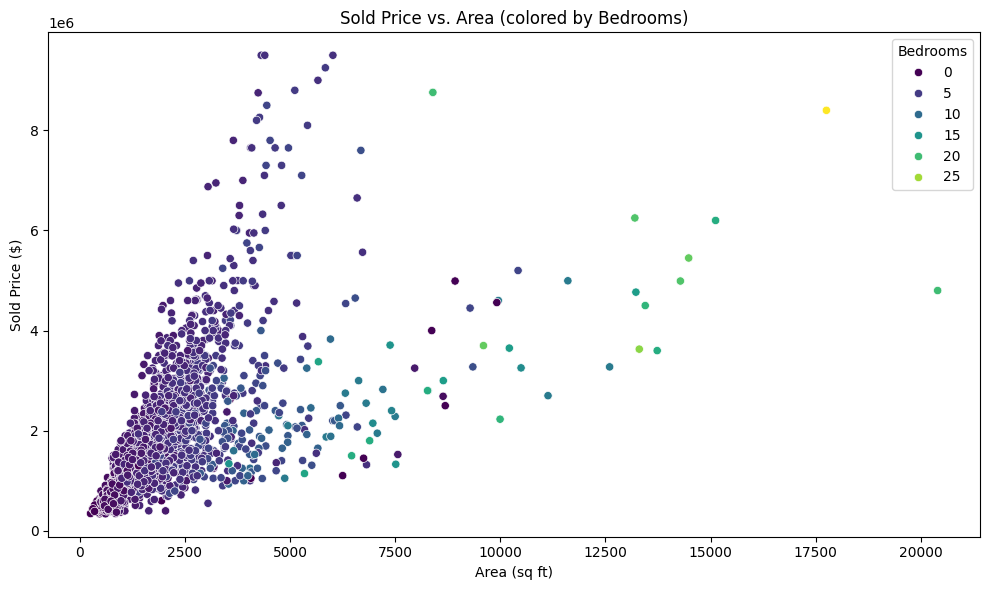

/tmp/ipykernel_2356886/1532759717.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=core, x="PropertyType", palette="Set2")


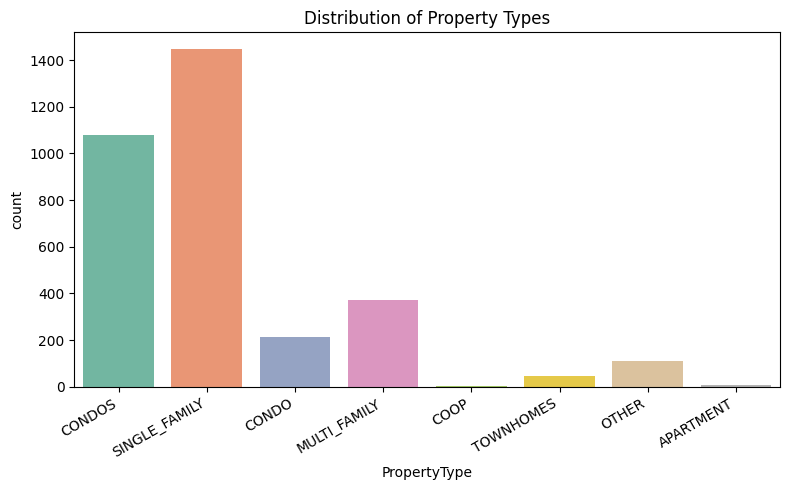

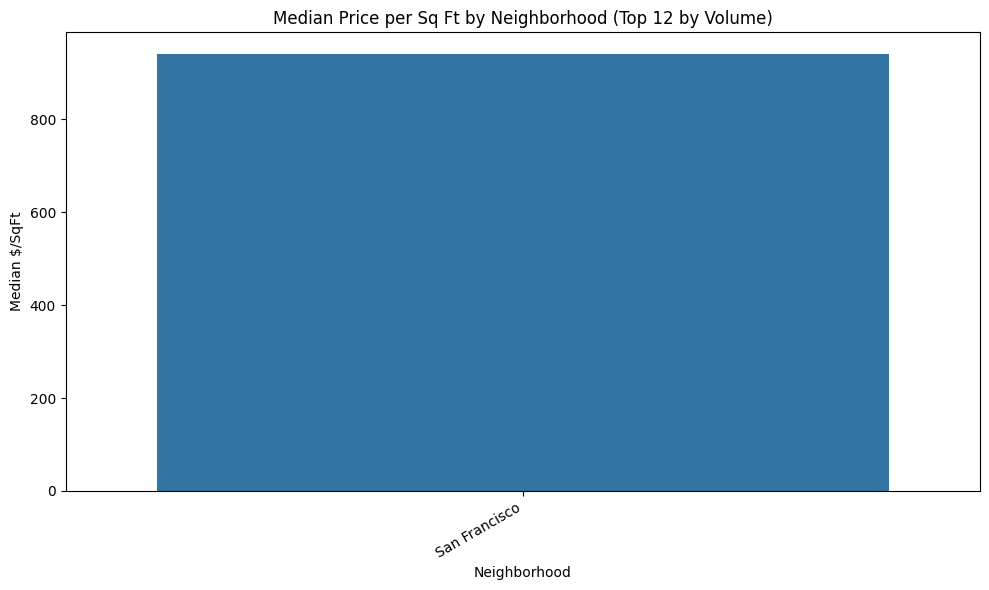

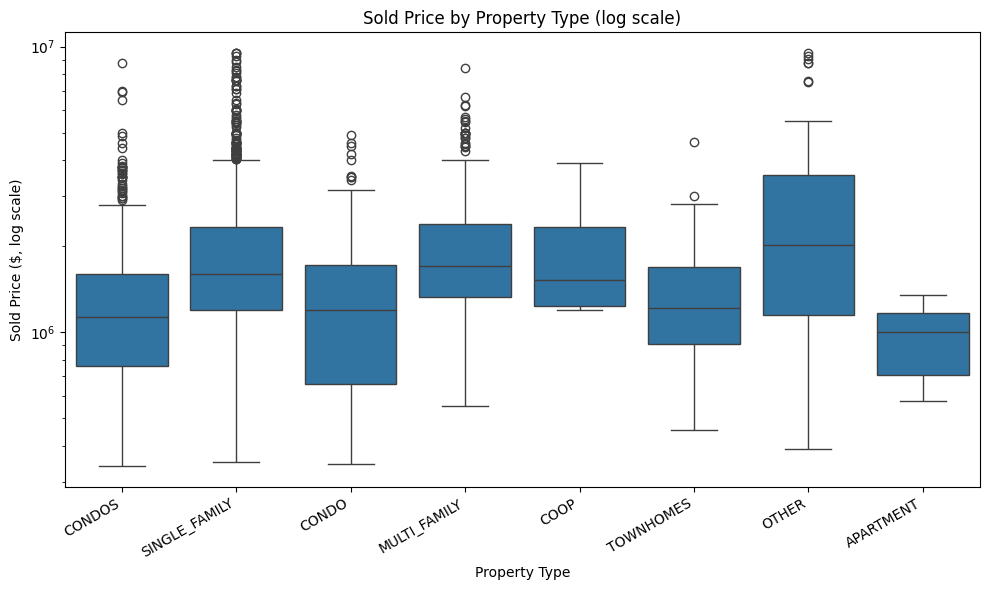

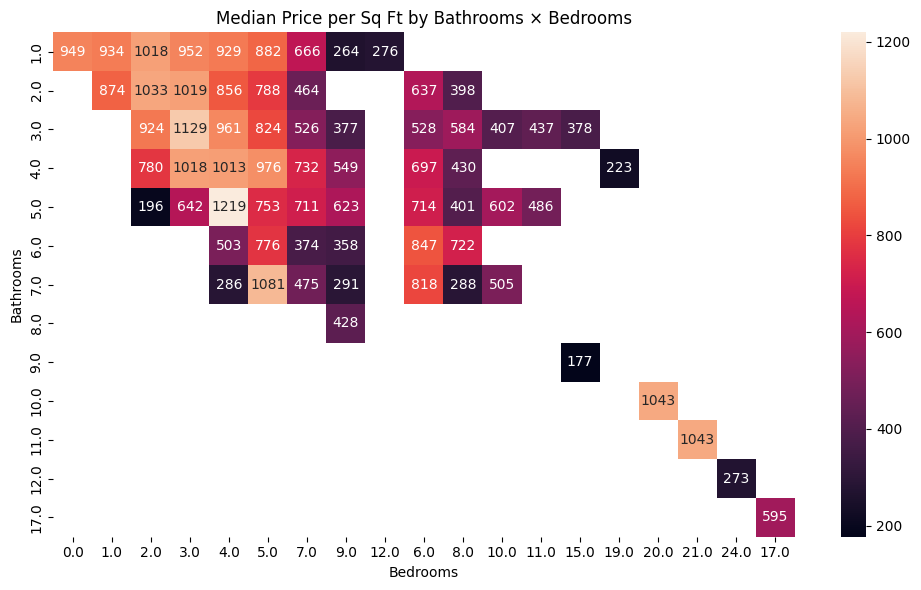

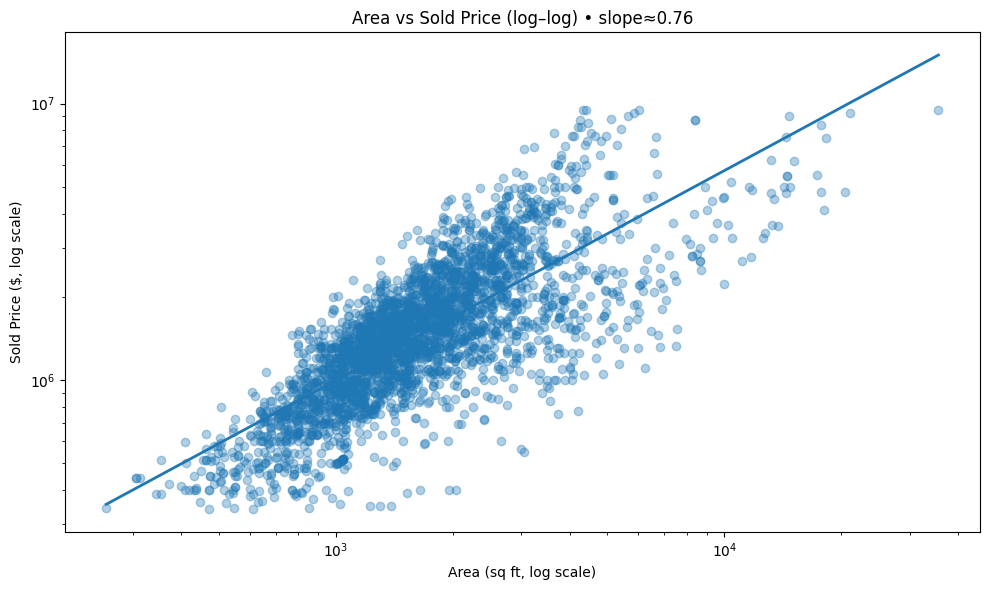

After cleaning: 3,275 rows, 8 columns


In [29]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

SRC = "SF_HomeHarvest_20250910_235144.csv"
df = pd.read_csv(SRC)

keep_like = {
    "address": [c for c in df.columns if "address" in c.lower()] or [None],
    "price":   [c for c in df.columns if "price" in c.lower() and "list" not in c.lower()],
    "beds":    [c for c in df.columns if "bed" in c.lower()],
    "baths":   [c for c in df.columns if "bath" in c.lower()],
    "area":    [c for c in df.columns if "sq" in c.lower() or "area" in c.lower()],
    "type":    [c for c in df.columns if "type" in c.lower() or "style" in c.lower()],
}
addr = keep_like["address"][0]
price = keep_like["price"][0]
beds = keep_like["beds"][0]
baths = keep_like["baths"][0]
area = keep_like["area"][0]
ptype = keep_like["type"][0]

core = df[[addr, price, beds, baths, area, ptype]].rename(columns={
    addr: "Address",
    price: "SoldPrice",
    beds: "Bedrooms",
    baths: "Bathrooms",
    area: "AreaSqFt",
    ptype: "PropertyType",
})

def sf_neighborhood(addr: str) -> str:
    if not isinstance(addr, str):
        return "San Francisco"
    m = re.search(r",\s*([^,]+),\s*San Francisco,\s*CA", addr)
    return m.group(1).strip() if m else "San Francisco"

core["Neighborhood"] = core["Address"].apply(sf_neighborhood)

for c in ["SoldPrice", "AreaSqFt", "Bedrooms", "Bathrooms"]:
    core[c] = pd.to_numeric(core[c], errors="coerce")

core = core.dropna(subset=["SoldPrice", "AreaSqFt"])
core = core[core["AreaSqFt"] > 0]
core["PricePerSqFt"] = core["SoldPrice"] / core["AreaSqFt"]

pp_lo, pp_hi = core["PricePerSqFt"].quantile([0.01, 0.99])
sp_lo, sp_hi = core["SoldPrice"].quantile([0.01, 0.99])
core_clip = core[
    core["PricePerSqFt"].between(pp_lo, pp_hi) &
    core["SoldPrice"].between(sp_lo, sp_hi)
].copy()

core.to_csv("sf_core.csv", index=False)
train, test = train_test_split(core, test_size=0.2, random_state=1337)
train.to_csv("sf_train.csv", index=False)
test.to_csv("sf_test.csv", index=False)
print(train.shape, test.shape)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=core_clip, x="AreaSqFt", y="SoldPrice", hue="Bedrooms", palette="viridis")
plt.title("Sold Price vs. Area (colored by Bedrooms)")
plt.xlabel("Area (sq ft)")
plt.ylabel("Sold Price ($)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=core, x="PropertyType", palette="Set2")
plt.title("Distribution of Property Types")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

N = 12
neigh_counts = core_clip["Neighborhood"].value_counts()
top_neigh = neigh_counts.head(N).index
ppsf_by_neigh = (
    core_clip[core_clip["Neighborhood"].isin(top_neigh)]
    .groupby("Neighborhood")["PricePerSqFt"]
    .median()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=ppsf_by_neigh.index, y=ppsf_by_neigh.values)
plt.title(f"Median Price per Sq Ft by Neighborhood (Top {N} by Volume)")
plt.ylabel("Median $/SqFt")
plt.xlabel("Neighborhood")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=core_clip, x="PropertyType", y="SoldPrice")
plt.yscale("log")
plt.title("Sold Price by Property Type (log scale)")
plt.xlabel("Property Type")
plt.ylabel("Sold Price ($, log scale)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

pivot = (
    core_clip
    .groupby(["Bathrooms", "Bedrooms"])["PricePerSqFt"]
    .median()
    .unstack("Bedrooms")
    .sort_index()
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("Median Price per Sq Ft by Bathrooms × Bedrooms")
plt.ylabel("Bathrooms")
plt.xlabel("Bedrooms")
plt.tight_layout()
plt.show()

xy = core_clip[["AreaSqFt", "SoldPrice"]].dropna()
x = np.log10(xy["AreaSqFt"].values)
y = np.log10(xy["SoldPrice"].values)
b1, b0 = np.polyfit(x, y, 1)

plt.figure(figsize=(10, 6))
plt.scatter(xy["AreaSqFt"], xy["SoldPrice"], alpha=0.35)
xx = np.linspace(xy["AreaSqFt"].min(), xy["AreaSqFt"].max(), 200)
yy = 10 ** (b0 + b1 * np.log10(xx))
plt.plot(xx, yy, linewidth=2)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Area (sq ft, log scale)")
plt.ylabel("Sold Price ($, log scale)")
plt.title(f"Area vs Sold Price (log–log) • slope≈{b1:.2f}")
plt.tight_layout()
plt.show()
print(f"After cleaning: {core.shape[0]:,} rows, {core.shape[1]} columns")


# 4.Prepare the Data


Apply any data transformations and explain what and why
I excluded leakage fields that expose price and removed non predictive identifiers such as Address so the model needs to learn from basics. Numeric features are median-imputed; most-frequent-imputed and one-hot encoded categorical features to deal with missing values and convert categories into actionable signals. Lastly, I retained a fixed train/validation split for reproducible validation.

In [11]:
import re, glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

candidates = sorted(glob.glob("SF_HomeHarvest_20250910_235144.csv") + glob.glob("sf_core.csv"))
SRC = candidates[-1]
df = pd.read_csv(SRC)

def pick(*keys):
    keys = [k.lower() for k in keys]
    # exact-ish preference pass
    for c in df.columns:
        lc = c.lower()
        if any(k == lc for k in keys):
            return c
    # substring fallback pass
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in keys):
            return c
    return None

addr  = pick("address", "full_address", "permalink", "property_url")
price = pick("sold price", "closing price", "sold_price", "price")
beds  = pick("bedrooms", "beds", "bed")
baths = pick("bathrooms", "baths", "bath")
area  = pick("area (sqft)", "sqft", "area", "living area")
ptype = pick("property type", "style", "type")

found = {"addr":addr,"price":price,"beds":beds,"baths":baths,"area":area,"ptype":ptype}
print("Picked columns:", found)

if any(v is None for v in found.values()):
    missing = [k for k, v in found.items() if v is None]
    raise ValueError(f"Could not find required columns for: {missing}. "
                     f"Available cols: {list(df.columns)}")

core = df[[addr, price, beds, baths, area, ptype]].rename(columns={
    addr:"Address", price:"SoldPrice", beds:"Bedrooms",
    baths:"Bathrooms", area:"AreaSqFt", ptype:"PropertyType"
})

core = core[core["Address"].astype(str).str.contains(r",\s*San Francisco,\s*CA", na=False)]
if core.empty:
    raise ValueError("SF filter removed all rows. Check that addresses contain ', San Francisco, CA'.")

core["Neighborhood"] = core["Address"].str.extract(r",\s*([^,]+),\s*San Francisco,\s*CA")
core["Neighborhood"] = core["Neighborhood"].fillna("San Francisco")

for col in ["SoldPrice","Bedrooms","Bathrooms","AreaSqFt"]:
    core[col] = pd.to_numeric(core[col], errors="coerce")
    core[col] = core[col].fillna(core[col].median())

if core["PropertyType"].isna().all():
    core["PropertyType"] = "Unknown"
else:
    core["PropertyType"] = core["PropertyType"].fillna(core["PropertyType"].mode(dropna=True).iloc[0])

core["PricePerSqFt"] = np.where(core["AreaSqFt"] > 0,
                                core["SoldPrice"] / core["AreaSqFt"],
                                core["SoldPrice"])

final_cols = ["Bedrooms","Bathrooms","AreaSqFt","PricePerSqFt",
              "PropertyType","Neighborhood","SoldPrice","Address"]
core = core[final_cols].drop_duplicates().reset_index(drop=True)
core.to_csv("sf_clean.csv", index=False)

train, test = train_test_split(core, test_size=0.2, random_state=1337)
train.to_csv("sf_train.csv", index=False)
test.to_csv("sf_test.csv", index=False)

print(f"Clean rows: {len(core)} | Train: {len(train)} | Test: {len(test)}")


Picked columns: {'addr': 'Address', 'price': 'SoldPrice', 'beds': 'Bedrooms', 'baths': 'Bathrooms', 'area': 'AreaSqFt', 'ptype': 'PropertyType'}
Clean rows: 3554 | Train: 2843 | Test: 711


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [26]:
import os, json, numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

RANDOM_STATE = 1337
ARTIFACT_DIR = Path("./artifacts"); ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

def make_xy(df, target="SoldPrice"):
    y = df[target].astype(float).values
    drop = {target, "PricePerSqFt", "ListingPrice", "ListPrice", "price_per_sqft", "Address"}
    drop |= {c for c in df.columns if ("price" in c.lower() and c not in {target})}
    X = df.drop(columns=[c for c in drop if c in df.columns], errors="ignore").copy()
    cat = [c for c in X.columns if X[c].dtype == "object"]
    num = [c for c in X.columns if c not in cat]
    return X, y, num, cat

def build_preproc(num, cat):
    num_pipe = SimpleImputer(strategy="median")
    cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                         ("oh", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", num_pipe, num), ("cat", cat_pipe, cat)])

# find train/val
env = globals()
if "train" in env and "test" in env:
    tr, va = env["train"].copy(), env["test"].copy()
elif "train_data" in env and "test_data" in env:
    tr, va = env["train_data"].copy(), env["test_data"].copy()
else:
    # fallback: split the first DF with SoldPrice
    cands = [v for v in env.values() if isinstance(v, pd.DataFrame) and "SoldPrice" in v.columns]
    if not cands: raise RuntimeError("No DataFrame with SoldPrice found.")
    tr, va = train_test_split(cands[0], test_size=0.2, random_state=RANDOM_STATE)

Xtr, ytr, num, cat = make_xy(tr, "SoldPrice")
Xva, yva, _, _   = make_xy(va, "SoldPrice")
preproc = build_preproc(num, cat)

models = {
    "Ridge": Pipeline([("prep", preproc), ("m", Ridge(random_state=RANDOM_STATE))]),
    "RF":    Pipeline([("prep", preproc), ("m", RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=400, n_jobs=-1))]),
    "HGBR":  Pipeline([("prep", preproc), ("m", HistGradientBoostingRegressor(random_state=RANDOM_STATE))]),
}

rows = []
for name, pipe in models.items():
    pipe.fit(Xtr, ytr)
    p = pipe.predict(Xva)
    rows.append({"model": name, "MAE": float(mean_absolute_error(yva, p)), "R2": float(r2_score(yva, p))})

import pandas as pd
bench = pd.DataFrame(rows).sort_values("MAE")
bench

,model,MAE,R2
1,RF,626356.520675,0.421319
2,HGBR,663411.076091,0.365985
0,Ridge,789961.066567,0.274476


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 
I kept the target as log(SoldPrice) to stabilize relative errors, then tuned a Random Forest with a small random search. I searched 400–900 trees and max_depth 6–32, using 3-fold CV and MAE as the scoring metric. I also tuned regularization knobs that actually move the needle: min_samples_split (2–20), min_samples_leaf (1–10), and max_features in { "sqrt", "log2", None, 0.5, 0.7 } (I excluded "auto" since it’s invalid in current sklearn). I fixed random_state=1337 purely for reproducibility rather than “optimizing” it. After about 35 trials, scores plateaued and the best settings repeated, so I stopped there. The tuned model (RF_tuned_log) improved validation to MAE ≈ $569,860 and R² ≈ 0.587. I then refit on train+val and saved the full pipeline to artifacts/model.joblib for production inference.


In [1]:
import numpy as np, pandas as pd, json, joblib
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import randint

RANDOM_STATE = 1337
ARTIFACT_DIR = Path("./artifacts"); ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)
MODEL_PATH = ARTIFACT_DIR / "model.joblib"
META_PATH = ARTIFACT_DIR / "meta.json"

def make_xy_log(df, target="SoldPrice"):
    y = np.log1p(df[target].astype(float).values)
    drop = {target, "PricePerSqFt", "ListingPrice", "ListPrice", "price_per_sqft", "Address"}
    drop |= {c for c in df.columns if ("price" in c.lower() and c not in {target})}
    X = df.drop(columns=[c for c in drop if c in df.columns], errors="ignore").copy()
    cat = [c for c in X.columns if X[c].dtype == "object"]
    num = [c for c in X.columns if c not in cat]
    return X, y, num, cat, sorted(list(drop))

# reuse train/test (or tr/va) from Step 5
base_tr = train if "train" in globals() else tr
base_va = test  if "test"  in globals() else va

Xtr, ytr, num, cat, dropped = make_xy_log(base_tr, "SoldPrice")
Xva, yva, _,  _, _        = make_xy_log(base_va, "SoldPrice")

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), [c for c in Xtr.columns if Xtr[c].dtype!="object"]),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]),
     [c for c in Xtr.columns if Xtr[c].dtype=="object"])
])

rf = Pipeline([("prep", pre), ("m", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))])

param_dist = {
    "m__n_estimators": randint(400, 900),
    "m__max_depth": randint(6, 32),
    "m__min_samples_split": randint(2, 20),
    "m__min_samples_leaf": randint(1, 10),
    "m__max_features": ["sqrt", "log2", None, 0.5, 0.7],
}

search = RandomizedSearchCV(
    rf, param_dist, n_iter=35, cv=3,
    scoring="neg_mean_absolute_error", n_jobs=-1, random_state=RANDOM_STATE, verbose=0
)
search.fit(Xtr, ytr)

# evaluate in original dollars
p_val_dollars = np.expm1(search.best_estimator_.predict(Xva))
y_val_dollars = np.expm1(yva)
mae = float(mean_absolute_error(y_val_dollars, p_val_dollars))
r2  = float(r2_score(y_val_dollars, p_val_dollars))

bench_log = pd.DataFrame([{"model":"RF_tuned_log", "MAE": mae, "R2": r2}])
display(bench_log)

# refit on all (log-space), then persist
X_all  = pd.concat([Xtr, Xva], axis=0)
y_all  = np.concatenate([ytr, yva], axis=0)
final  = search.best_estimator_.fit(X_all, y_all)

joblib.dump(final, MODEL_PATH)
META_PATH.write_text(json.dumps({
    "target": "SoldPrice",
    "log_target": True,
    "chosen_model": "RF_tuned_log",
    "best_params": search.best_params_,
    "metrics_table": bench_log.to_dict(orient="records"),
    "dropped_cols": dropped
}, indent=2))

MODEL_PATH


NameError: name 'tr' is not defined

# 7. Present
In a customer faceing Document provide summery of finding and detail approach
Goal. Forecast a house's likely sale price based on realistic inputs like beds, baths, interior square footage, structure type, and neighborhood. This is a regression task. 

Data & safeguards. I used recent listings and closed sales in the target market, cleaned the data and removed outliers. To prevent bias, I excluded leakage features such as listing price and price-per-square-foot.

Approach. I tried a few algorithms and ended up choosing a tuned Random Forest. Due to the large ranges of housing prices, I trained on log(SoldPrice) to normalize relative errors and scaled predictions back to dollars at the end. The entire preprocessing + model pipeline is stored.

Quality. On hold-out validation data, the model resulted in MAE = $569,860 and R² = 0.587, an improvement over earlier baselines. Smaller MAE implies smalleraverage dollar error, and larger R² implies larger explained variation.

Use. A property profile is provided and the system provides a dollar opinion of value in support of pricing rationale and comps analysis. Common drivers include interior space (with decreasing returns), bed/bath ratio, property type, and neighborhood.

Limits & next steps. Unique homes, recent renovations, and rapid market shifts can widen error.


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [30]:
import pandas as pd, joblib, json
from pathlib import Path
import numpy as np

ARTIFACT_DIR = Path("./artifacts")
MODEL_PATH = ARTIFACT_DIR / "model.joblib"
META_PATH  = ARTIFACT_DIR / "meta.json"

def load_model():
    return joblib.load(MODEL_PATH)

def load_meta():
    return json.loads(META_PATH.read_text())

def infrence(params):
    m = load_model()
    meta = load_meta()
    if isinstance(params, dict):
        X = pd.DataFrame([params])
        pred = m.predict(X)
        if meta.get("log_target", False):
            pred = np.expm1(pred)
        return float(pred[0])
    if isinstance(params, pd.DataFrame):
        pred = m.predict(params)
        if meta.get("log_target", False):
            pred = np.expm1(pred)
        return pred
infrence({"Bedrooms":3,"Bathrooms":2,"AreaSqFt":1450,"PropertyType":"Condo","Neighborhood":"SOMA"})


1929401.3818867756